In [1]:
import numpy as np
import glob
import os
print(os.getcwd())
from iqtools import *

/home/gpuuser


In [3]:
def get_files_in_range(folder_path, start_index, end_index):
    # List all files in the folder and sort them by creation time
    file_list = sorted(os.listdir(folder_path), key=lambda f: os.path.getctime(os.path.join(folder_path, f)))
    
    if start_index < 0 or end_index >= len(file_list):
        print("Error: Indices out of range.")
        return []
    
    selected_files = file_list[start_index:end_index + 1]
    return [os.path.join(folder_path, file) for file in selected_files]


# Example usage
#folder_path = "/data.local/G22-00018_00203/results/analyzers/RSA01/"
folder_path = "/home/gpuuser/sshfs_mounts/lustre/ap/litv-exp/2024-05-12_E018_TwoPhotonDecay_ssanjari/analyzers/RSA01_P1/"
saving_path = "/home/gpuuser/sshfs_mounts/lustre/astrum/cforconi/data_analysis/plots/"      # CHANGE
saving_path_plots = "/home/gpuuser/sshfs_mounts/lustre/astrum/cforconi/data_analysis/plots/"
saving_path_mydir = "/home/gpuuser/sshfs_mounts/lustre/astrum/cforconi/data_analysis/npz_files/"

start_index = 9386    #23591  # Change this to your desired start index
end_index = 9925       # Change this to your desired end index

files = get_files_in_range(folder_path, start_index, end_index)
print("Selected files:", files)

filename_1 = files[0]
filename_2 = files[-1]
parts_1 = filename_1.split('.')
parts_2 = filename_2.split('.')
date_part = '.'.join(parts_1[:3])  # e.g., RSA01-2025.04.02
start_time = f"{parts_1[3]}:{parts_1[4]}"  # e.g., 05:02
end_time = f"{parts_2[3]}:{parts_2[4]}"    # e.g., 12:00

# Combine into final name
combined_name = f"{date_part}_{start_time}_{end_time}"
print(combined_name)


Selected files: ['/home/gpuuser/sshfs_mounts/lustre/ap/litv-exp/2024-05-12_E018_TwoPhotonDecay_ssanjari/analyzers/RSA01_P1/RSA01-2024.05.15.21.39.38.952.tiq', '/home/gpuuser/sshfs_mounts/lustre/ap/litv-exp/2024-05-12_E018_TwoPhotonDecay_ssanjari/analyzers/RSA01_P1/RSA01-2024.05.15.21.39.44.991.tiq', '/home/gpuuser/sshfs_mounts/lustre/ap/litv-exp/2024-05-12_E018_TwoPhotonDecay_ssanjari/analyzers/RSA01_P1/RSA01-2024.05.15.21.39.53.010.tiq', '/home/gpuuser/sshfs_mounts/lustre/ap/litv-exp/2024-05-12_E018_TwoPhotonDecay_ssanjari/analyzers/RSA01_P1/RSA01-2024.05.15.21.39.59.047.tiq', '/home/gpuuser/sshfs_mounts/lustre/ap/litv-exp/2024-05-12_E018_TwoPhotonDecay_ssanjari/analyzers/RSA01_P1/RSA01-2024.05.15.21.40.05.125.tiq', '/home/gpuuser/sshfs_mounts/lustre/ap/litv-exp/2024-05-12_E018_TwoPhotonDecay_ssanjari/analyzers/RSA01_P1/RSA01-2024.05.15.21.40.11.163.tiq', '/home/gpuuser/sshfs_mounts/lustre/ap/litv-exp/2024-05-12_E018_TwoPhotonDecay_ssanjari/analyzers/RSA01_P1/RSA01-2024.05.15.21.40.19

In [6]:
t_cut_start = 0.4             # s
t_cut_stop = 1.5              # s
#x_cut_start = 32760
#x_cut_stop = 32775
#reference_freq = 410535252     # Hz
#freq_bin_size = 762.939453125   # Hz
peak_height_cut = 0
#print(reference_freq)

lframes = 2**16
nframes = 171

In [16]:
iq = get_iq_object(files[0])
iq.read(lframes=lframes, nframes=nframes)
iq.method="fftw"
xx0, yy0, zz0 = iq.get_power_spectrogram(lframes=lframes, nframes=nframes)

zz_summed = np.zeros_like(zz0)
zz_corrected = np.zeros_like(zz0)
zz_corrected_sum = np.zeros_like(zz0)

freq_bin_size = iq.fs/lframes
t_bin_size = 1/freq_bin_size
#nframes = int((iq.nsamples_total/iq.fs)/t_bin_size)
reference_freq = iq.center
nsamples_total = iq.nsamples_total
#nframes = largest_power_of_2(iq.nsamples_total / lframes)
AVG = 4
print("lframes: ",lframes,"\nnframes :", nframes)
print("Total Number of Samples: ", iq.nsamples_total)
print("Center Frequency :", iq.center / 10**6, "MHz")
print("Sampling Rate :", iq.fs / 10**6, "MHz")
print("Freq bin size :", freq_bin_size)

lframes:  65536 
nframes : 171
Total Number of Samples:  11250000
Center Frequency : 408.3955 MHz
Sampling Rate : 6.25 MHz
Freq bin size : 95.367431640625


In [17]:
t_total = yy0[-1][0]
fs = nsamples_total/t_total
#freq_bin_size = fs/lframes

x_cut_start = int(lframes/2) - 5
x_cut_stop = int(lframes/2) + 5

y_bin_start = int(t_cut_start/t_bin_size)
y_bin_stop = int(t_cut_stop/t_bin_size)
y_range = np.arange(y_bin_start, y_bin_stop)
t_range = np.linspace(t_cut_start, t_cut_stop, len(y_range))

bandwidth = lframes * freq_bin_size    #Hz
#reference_freq = (xx0[0][0] + xx0[0][-1]) / 2

tot_bin_number = bandwidth/freq_bin_size
tot_freq = reference_freq + bandwidth/2
iq_center = reference_freq
freq_min = iq_center - bandwidth/2
freq_max = iq_center + bandwidth/2
reference_bin = int((reference_freq - iq_center + bandwidth/2)/freq_bin_size)        # with this function you can find any bin
peak_height_list = []

print("Bandwidth:  ", bandwidth, " Hz")
print("Reference Frequency  :", reference_freq, " Hz")
print("reference bin:", reference_bin)

print(reference_bin*freq_bin_size)

Bandwidth:   6250000.0  Hz
Reference Frequency  : 408395500.0  Hz
reference bin: 32768
3125000.0


In [ ]:
if not files:
    print("No matching files found.")
    exit()

xx, yy, zz = None, None, None

for file in files:
    iq = get_iq_object(file)
    iq.read(lframes=lframes, nframes=nframes)
    iq.method="fftw"
    xx, yy, zz = iq.get_power_spectrogram(lframes=lframes, nframes=nframes)

    zz_window = zz[y_bin_start:, x_cut_start:x_cut_stop]
    proj_x = zz_window.sum(axis=0)
    max_idx = np.argmax(proj_x)
    x_at_max = xx[0, x_cut_start+max_idx]
    peak_height = proj_x[max_idx]
    peak_height_list.append(peak_height)
    index = x_cut_start + max_idx
    bin_shift = int(round(index - reference_bin))

    if peak_height > peak_height_cut:
        zz_shifted = np.roll(zz, shift=-bin_shift, axis=1)
        zz_summed += zz_shifted
        proj_x_sum = zz_summed[y_bin_start:, x_cut_start:x_cut_stop].sum(axis=0)
        max_idx_sum = x_cut_start + np.argmax(proj_x_sum)
    
        ref_idx = np.argmax(zz_shifted[y_bin_start:, x_cut_start:x_cut_stop].sum(axis=0))
        for i in range(len(zz)):
            bin_diff = np.argmax(zz_shifted[i, x_cut_start:x_cut_stop]) - ref_idx
            zz_corrected[i] = np.roll(zz_shifted[i], shift=-bin_diff)
        
        zz_corrected_sum += zz_corrected

output_filename = "/home/gpuuser/sshfs_mounts/lustre/astrum/cforconi/data_analysis/npz_files/injection_corrected/" + f"summed_{combined_name}_cut={peak_height_cut}_nframes={nframes}.npz"
np.savez(output_filename, xx, yy, zz_corrected_sum)
print(f"Summed data saved to: \n{output_filename}")

NameError: name 'nfames' is not defined

In [ ]:
print(zz_corrected_sum)

[[0.00040066 0.00041045 0.00036739 ... 0.00037124 0.00053301 0.00058141]
 [0.0004546  0.00055943 0.00073195 ... 0.00048522 0.00044977 0.00043621]
 [0.00059784 0.00042498 0.00028596 ... 0.00035804 0.000381   0.00040003]
 ...
 [0.000345   0.00062386 0.00041784 ... 0.00041767 0.00040492 0.00045497]
 [0.00048114 0.00036073 0.00036064 ... 0.0004839  0.00061735 0.00039208]
 [0.00043832 0.00051313 0.0003852  ... 0.00041834 0.00039447 0.00053235]]


In [ ]:
print(xx[y_bin_start, index])

diff = np.diff(xx[0])
print(diff)
print(len(xx[0]))
print(index)
freq_sum = sum(diff[:32768])
print(freq_sum + iq_center-bandwidth/2)

410537540.0
[1504. 1536. 1504. ... 1504. 1536. 1504.]
32920
16461
447746400.0


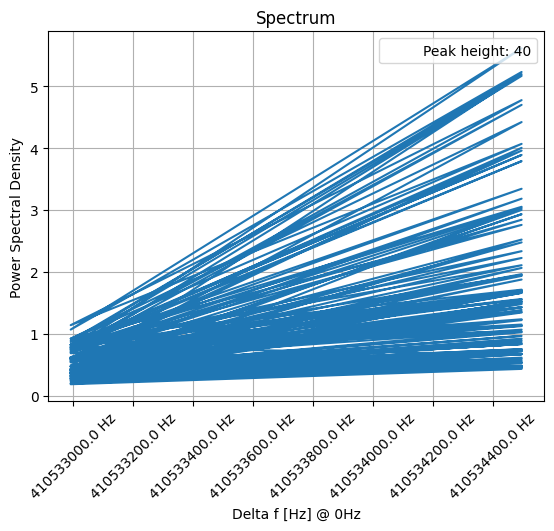

In [ ]:
from iqtools import plotters, tools
import matplotlib.pyplot as plt
%matplotlib inline

sly = slice(int(t_cut_start/t_bin_size), int(t_cut_stop/t_bin_size))
slx = slice(x_cut_start+3, x_cut_stop-5)

fig, ax = plt.subplots()
plotters.plot_spectrum(xx[sly,slx], 
                    zz_corrected_sum[sly,slx], 
                    cen=0.0, 
                    span=None, 
                    dbm=False, 
                    filename=None) 
#plt.xlim(-20e3, 10e3)
plt.xticks(rotation=45)  # Rotate labels for better readability
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1e0:.1f} Hz"))

ax.plot([], [], ' ', label=f"Peak height: {peak_height_cut}")
ax.legend(loc='upper right')


filename = f"Spectrum_{combined_name}_cut={peak_height_cut}.png"
save_path = f"{saving_path_plots}{filename}"
fig.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

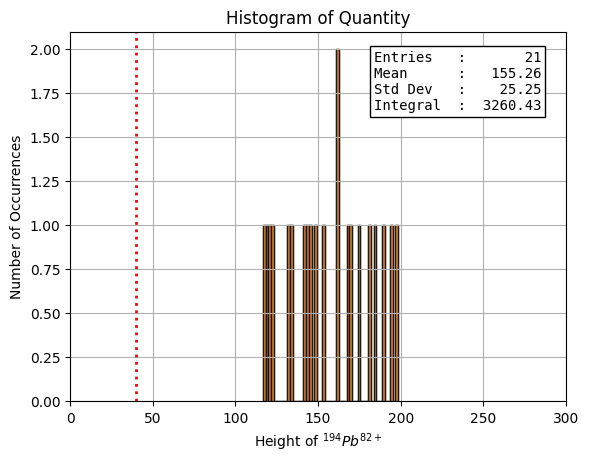

In [ ]:
fig, ax = plt.subplots()
plt.hist(peak_height_list, bins=50, edgecolor='black', alpha=0.7)


# Compute statistics
entries = len(peak_height_list)
mean = np.mean(peak_height_list)
std_dev = np.std(peak_height_list)
integral = np.sum(peak_height_list)

# Vertical red dotted line
vline_pos = peak_height_cut

# Create histogram
counts, bins, patches = ax.hist(peak_height_list, bins=50, edgecolor='black', alpha=0.7)

# Vertical line
ax.axvline(x=vline_pos, color='red', linestyle='dotted', linewidth=2)

# Axis labels
plt.xlabel(r'Height of $^{194}Pb^{82+}$')
plt.ylabel('Number of Occurrences')
plt.title('Histogram of Quantity')
plt.grid(True)

# Aligned text with monospace font
textstr = '\n'.join([
    f'Entries   : {entries:>8}',
    f'Mean      : {mean:>8.2f}',
    f'Std Dev   : {std_dev:>8.2f}',
    f'Integral  : {integral:>8.2f}'
])

# Box properties + monospace font
props = dict(boxstyle='square', facecolor='white', edgecolor='black')
ax.text(0.95, 0.95, textstr,
        transform=ax.transAxes,
        fontsize=10,
        fontfamily='monospace',   # 🔥 Monospaced for perfect alignment
        verticalalignment='top',
        horizontalalignment='right',
        bbox=props)
ax.set_xlim(0,  300)

filename = f"Histogram_{combined_name}_cut={peak_height_cut}.png"
save_path = f"{saving_path_plots}{filename}"
fig.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()


In [ ]:

print(np.max(zz_corrected[y_bin_start:, x_cut_start:x_cut_stop]))



5.31809
